# exp073
線形補間の代わりに相対を含めたkalman + 再度異常値除去＋線形補間

In [23]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 

In [24]:
target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']

In [25]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

# ground_truthをもとにした異常値除去を行うcollection
rog_target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3',
              '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', '2021-03-16-US-RWC-2', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2',
              '2021-04-26-US-SVL-2', '2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1',
              '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1']

In [26]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [27]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [28]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [29]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [30]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)
    
def vis(df, phone):
    gt = get_ground_truth()
    gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
    tmp1 = df[df['phone']==phone].copy()
    tmp2 = gt[gt['phone']==phone].copy()
    
    tmp1['phoneName'] = 'train'
    tmp2['phoneName'] = 'gt'
    
    tmp = pd.concat([tmp1, tmp2])
    tmp['collectionName'] = 'all'
    
    lat_center = tmp['latDeg'].mean()
    lng_center = tmp['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
        
    visualize_trafic(tmp, center)

In [31]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [32]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [33]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [34]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

# 現在のベストスコア確認

In [35]:
df = pd.read_csv('../output/exp056/train.csv')
df = df[df['collectionName'].isin(target)]
res = train_result(df)
print(res.score)
display(res.err)

9.836789162255748


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               4.581442     16.134227     10.357834
2021-04-22-US-SJC-1_SamsungS20Ultra      4.214457     15.916886     10.065672
2021-04-28-US-SJC-1_Pixel4               3.159024     16.320795      9.739909
2021-04-28-US-SJC-1_SamsungS20Ultra      3.257959     16.580978      9.919468
2021-04-29-US-SJC-2_Pixel4               2.787590     16.190887      9.489239
2021-04-29-US-SJC-2_SamsungS20Ultra      2.754437     16.142788      9.448613

# 相対移動距離をもとにした外れ値除去

In [36]:
train, test, sub, gt = get_data()
train = train[train['collectionName'].isin(target)]
train_org = train.copy()

In [37]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [38]:
# reject outlier
train = add_distance_diff(train)
train.loc[((train['dist_prev'] > ro_th) & (train['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan
train.to_csv(OUTPUT + '/train_ro.csv', index=False)

# ground_truthを基準にした外れ値除去

In [39]:
def get_osmnx_data():
    p = pathlib.Path(INPUT)
    files = list(p.glob('prep/osmnx/*.csv'))

    dfs = []
    for file in files:
        dfs.append(pd.read_csv(file))
    osmnx = pd.concat(dfs)

    return osmnx

In [40]:
def remove_based_on_gt(target_df, target_gt, th):
    osmnx_data = get_osmnx_data()
    target_gt = target_gt.append(osmnx_data)
    
    for idx in target_df.index:
        lat = target_df.at[idx, 'latDeg']
        lng = target_df.at[idx, 'lngDeg']
        collection = target_df.at[idx, 'collectionName']
        
        if collection in ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']:
            th = 3
        
        if np.isnan(lat):
            continue
        else:
            target_gt['latDeg_pred'] = lat
            target_gt['lngDeg_pred'] = lng
            target_gt['dist'] = calc_haversine(target_gt['latDeg'], target_gt['lngDeg'], target_gt['latDeg_pred'], target_gt['lngDeg_pred'])
            closest_dist = target_gt['dist'].min()
            if closest_dist > th:
                target_df.at[idx, 'latDeg'] = np.nan
                target_df.at[idx, 'lngDeg'] = np.nan
    return target_df

In [41]:
def interpolate_remove_point(df):
    out_df = pd.DataFrame()
    collections = df['collectionName'].unique()
    
    for collection in collections:
        tmp = df[df['collectionName']==collection].copy()
        tmp = tmp.sort_values('millisSinceGpsEpoch')
        tmp = tmp.reset_index().set_index('millisSinceGpsEpoch')
        tmp[['latDeg', 'lngDeg']] = tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        tmp = tmp.sort_values('index')
        tmp = tmp.reset_index().set_index('index')
        out_df = out_df.append(tmp)
    return out_df

In [42]:
rog_df = train[train['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
train.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

# speed0の処理

In [43]:
def sp0_process(df, sp0_result):
    df = df.merge(sp0_result, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    df[['latDeg', 'lngDeg']] = df.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
    return df

In [44]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
train = sp0_process(train, train_sp0_pred)

# kalmanフィルタ(相対追加)

In [45]:
# 楕円体
ELLIPSOID_GRS80 = 1 # GRS80
ELLIPSOID_WGS84 = 2 # WGS84

# 楕円体別の長軸半径と扁平率
GEODETIC_DATUM = {
    ELLIPSOID_GRS80: [
        6378137.0,         # [GRS80]長軸半径
        1 / 298.257222101, # [GRS80]扁平率
    ],
    ELLIPSOID_WGS84: [
        6378137.0,         # [WGS84]長軸半径
        1 / 298.257223563, # [WGS84]扁平率
    ],
}

# 反復計算の上限回数
ITERATION_LIMIT = 1000

'''
Vincenty法(順解法)
始点の座標(緯度経度)と方位角と距離から、終点の座標と方位角を求める
:param lat: 緯度
:param lon: 経度
:param azimuth: 方位角
:param distance: 距離
:param ellipsoid: 楕円体
:return: 終点の座標、方位角
'''
def vincenty_direct(lat, lon, azimuth, distance, ellipsoid=None):

    # 計算時に必要な長軸半径(a)と扁平率(ƒ)を定数から取得し、短軸半径(b)を算出する
    # 楕円体が未指定の場合はGRS80の値を用いる
    a, ƒ = GEODETIC_DATUM.get(ellipsoid, GEODETIC_DATUM.get(ELLIPSOID_WGS84))
    b = (1 - ƒ) * a

    # ラジアンに変換する(距離以外)
    φ1 = radians(lat)
    λ1 = radians(lon)
    α1 = radians(azimuth)
    s = distance

    sinα1 = sin(α1)
    cosα1 = cos(α1)

    # 更成緯度(補助球上の緯度)
    U1 = atan((1 - ƒ) * tan(φ1))

    sinU1 = sin(U1)
    cosU1 = cos(U1)
    tanU1 = tan(U1)

    σ1 = atan2(tanU1, cosα1)
    sinα = cosU1 * sinα1
    cos2α = 1 - sinα ** 2
    u2 = cos2α * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))

    # σをs/(b*A)で初期化
    σ = s / (b * A)

    # 以下の計算をσが収束するまで反復する
    # 地点によっては収束しないことがあり得るため、反復回数に上限を設ける
    for i in range(ITERATION_LIMIT):
        cos2σm = cos(2 * σ1 + σ)
        sinσ = sin(σ)
        cosσ = cos(σ)
        Δσ = B * sinσ * (cos2σm + B / 4 * (cosσ * (-1 + 2 * cos2σm ** 2) - B / 6 * cos2σm * (-3 + 4 * sinσ ** 2) * (-3 + 4 * cos2σm ** 2)))
        σʹ = σ
        σ = s / (b * A) + Δσ

        # 偏差が.000000000001以下ならbreak
        if abs(σ - σʹ) <= 1e-12:
            break
    else:
        # 計算が収束しなかった場合はNoneを返す
        return None

    # σが所望の精度まで収束したら以下の計算を行う
    x = sinU1 * sinσ - cosU1 * cosσ * cosα1
    φ2 = atan2(sinU1 * cosσ + cosU1 * sinσ * cosα1, (1 - ƒ) * sqrt(sinα ** 2 + x ** 2))
    λ = atan2(sinσ * sinα1, cosU1 * cosσ - sinU1 * sinσ * cosα1)
    C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
    L = λ - (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
    λ2 = L + λ1

    α2 = atan2(sinα, -x) + pi

    return {
        'lat': degrees(φ2),     # 緯度
        'lon': degrees(λ2),     # 経度
        'azimuth': degrees(α2), # 方位角
    }

In [46]:
def add_delta_coordinate(df):
    df['lat_delta'] = np.nan
    df['lng_delta'] = np.nan
    
    idxs = df.index
    
    for idx in idxs:
        if idx == idxs[-1]:
            break

        lat = df.at[idx, 'latDeg']
        lng = df.at[idx, 'lngDeg']
        deg = df.at[idx, 'calc_deg']
        dist = df.at[idx, 'dist_pred']

        res = vincenty_direct(lat, lng, deg, dist, ellipsoid=None)
        if res is not None:
            df.at[idx, 'lat_delta'] = res['lat'] - lat
            df.at[idx, 'lng_delta'] = res['lon'] - lng
    
    return df

In [47]:
state_transition = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 1e-5, 1e-5]) + np.zeros((4, 4))
observation_model = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
observation_noise = np.diag([1e-5, 1e-5, 1e-6, 1e-6]) + np.zeros((4, 4))

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg', 'lat_delta', 'lng_delta']].to_numpy()
        data = data.reshape(1, len(data), 4)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [48]:
degree = pd.read_csv('../output/prep/degree_pred_v002/train_degree_pred.csv')
dist = pd.read_csv('../output/prep/distance_pred_v002/train_distance_pred.csv')
dist = dist.rename(columns={'pred': 'dist_pred'}) 
sp0 = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
train_org = train_org.merge(degree[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train_org = train_org.merge(dist[['phone', 'millisSinceGpsEpoch', 'dist_pred']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train_org = train_org.merge(sp0[['phone', 'millisSinceGpsEpoch', 'isSpeed0']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train_org.loc[train_org['isSpeed0']==1, 'dist_pred'] = 0

train_org = add_delta_coordinate(train_org)
train[['lat_delta', 'lng_delta']] = train_org[['lat_delta', 'lng_delta']]

In [49]:
train = apply_kf_smoothing(train)

In [50]:
res = train_result(train)
print(res.score)
display(res.err)

10.952316957598528


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               5.223693     21.620626     13.422160
2021-04-22-US-SJC-1_SamsungS20Ultra      5.023948     18.536730     11.780339
2021-04-28-US-SJC-1_Pixel4               3.120846     14.116984      8.618915
2021-04-28-US-SJC-1_SamsungS20Ultra      3.910627     17.694999     10.802813
2021-04-29-US-SJC-2_Pixel4               3.110389     16.925362     10.017875
2021-04-29-US-SJC-2_SamsungS20Ultra      3.988900     18.154699     11.071799

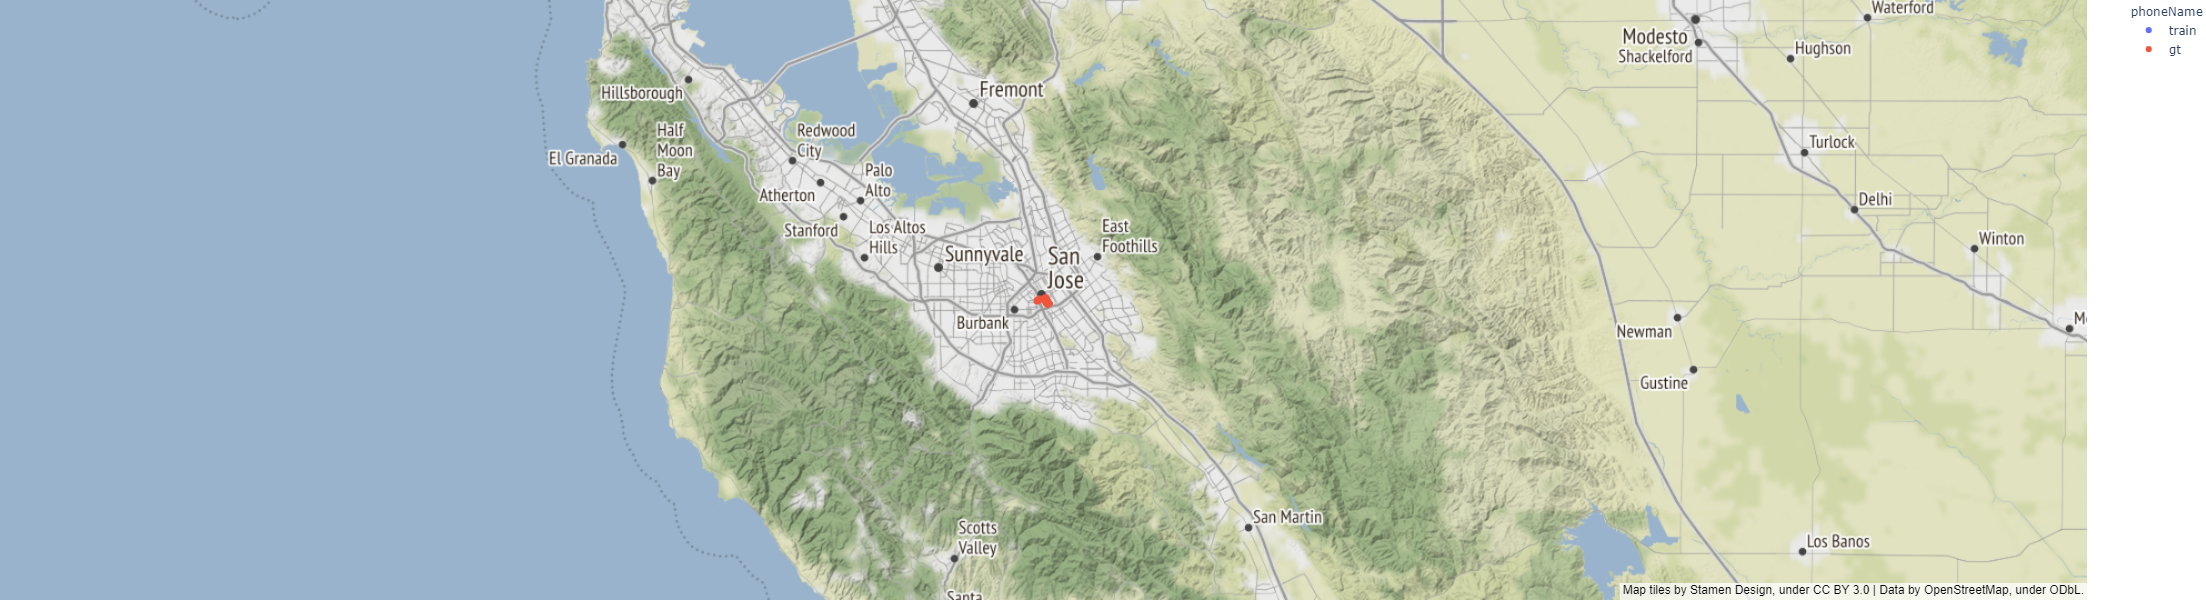

In [51]:
vis(train, '2021-04-22-US-SJC-1_Pixel4')

# 再度異常値削除・線形補間

In [52]:
train_after_kf = train.copy()

In [53]:
train = remove_based_on_gt(train, rog_gt, rog_th)
train = interpolate_remove_point(train)

In [54]:
res = train_result(train)
print(res.score)
display(res.err)

10.332844949877536


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               5.048836     18.830721     11.939778
2021-04-22-US-SJC-1_SamsungS20Ultra      4.684802     18.536730     11.610766
2021-04-28-US-SJC-1_Pixel4               3.075142     14.116984      8.596063
2021-04-28-US-SJC-1_SamsungS20Ultra      3.608192     14.360506      8.984349
2021-04-29-US-SJC-2_Pixel4               3.020333     16.925526      9.972929
2021-04-29-US-SJC-2_SamsungS20Ultra      3.632417     18.153952     10.893184

In [55]:
train = train_after_kf.copy()

In [56]:
train = remove_based_on_gt(train, rog_gt, 2)
train = interpolate_remove_point(train)

In [57]:
res = train_result(train)
print(res.score)
display(res.err)

10.332844949877536


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               5.048836     18.830721     11.939778
2021-04-22-US-SJC-1_SamsungS20Ultra      4.684802     18.536730     11.610766
2021-04-28-US-SJC-1_Pixel4               3.075142     14.116984      8.596063
2021-04-28-US-SJC-1_SamsungS20Ultra      3.608192     14.360506      8.984349
2021-04-29-US-SJC-2_Pixel4               3.020333     16.925526      9.972929
2021-04-29-US-SJC-2_SamsungS20Ultra      3.632417     18.153952     10.893184

# phones_mean

In [58]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')
    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])
    
    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)
    # Leave only records to be interpolated
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]
    
    return lerp_df[org_columns]

def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

In [59]:
train_lerp = make_lerp_data(train)
train = calc_mean_pred(train, train_lerp)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm.csv', index=False)

In [60]:
res = train_result(train)
print(res.score)
display(res.err)

9.564540379128953


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               4.917903     18.059369     11.488636
2021-04-22-US-SJC-1_SamsungS20Ultra      4.559613     17.866213     11.212913
2021-04-28-US-SJC-1_Pixel4               3.141010     13.384500      8.262755
2021-04-28-US-SJC-1_SamsungS20Ultra      3.054070     13.287516      8.170793
2021-04-29-US-SJC-2_Pixel4               3.201556     15.243470      9.222513
2021-04-29-US-SJC-2_SamsungS20Ultra      3.128512     14.930752      9.029632

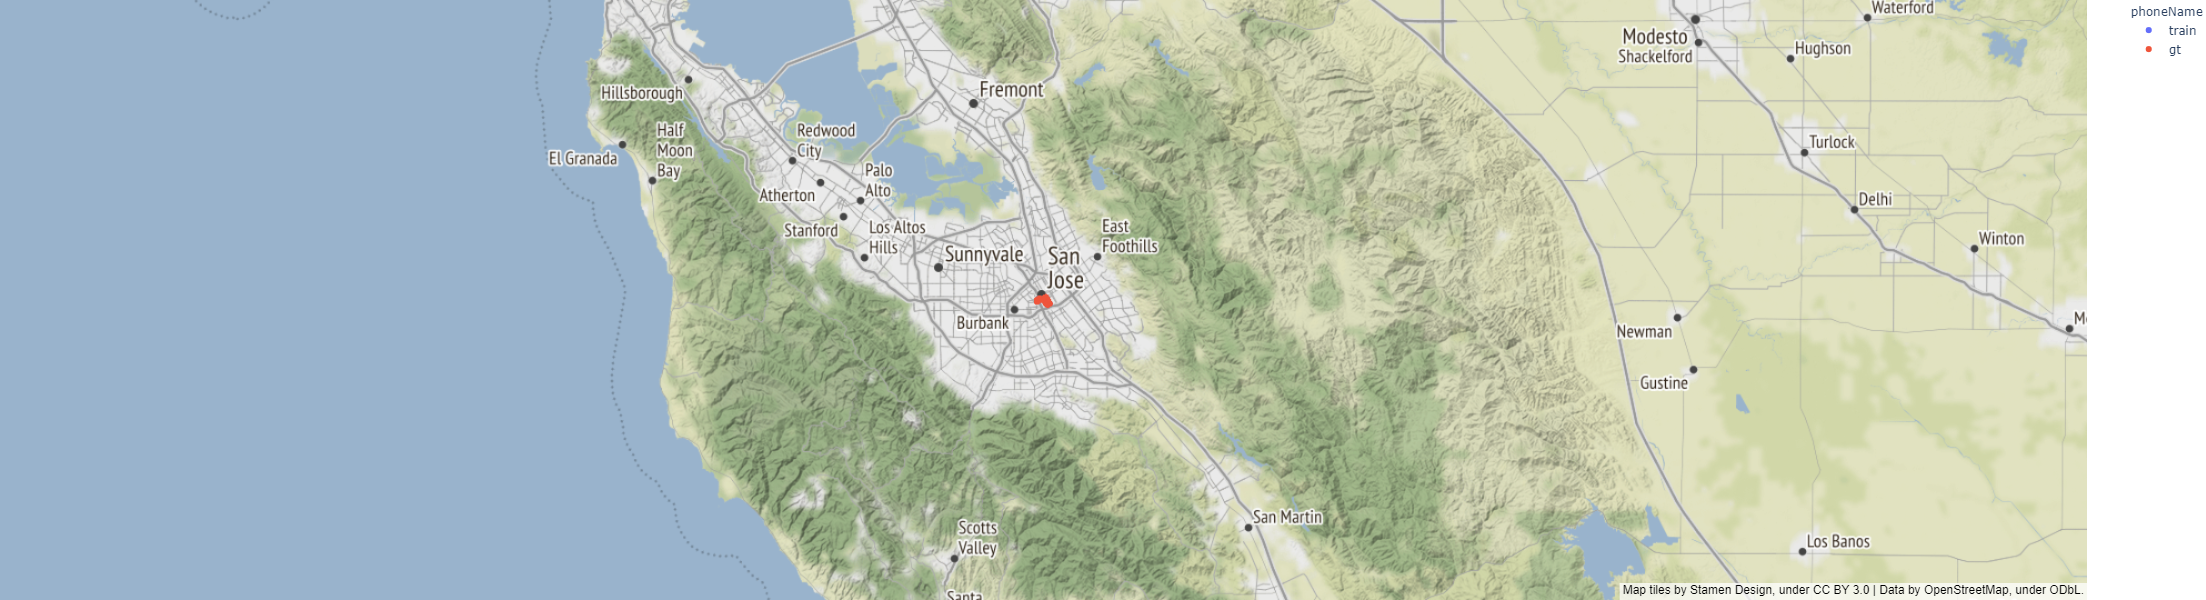

In [61]:
train['phone'] = train['collectionName'] + '_' + train['phoneName']
vis(train, '2021-04-22-US-SJC-1_Pixel4')

# position_shift

In [62]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt
msge = 'millisSinceGpsEpoch'

In [63]:
def position_shift(df,a):

    d = df.copy()
    d['heightAboveWgs84EllipsoidM'] = 63.5
    d['x'], d['y'], d['z'] = zip(*d.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    #a = -0.2
    d.sort_values(['phone', msge], inplace=True)
    for fi in ['x','y','z']:
        d[[fi+'p']] = d[fi].shift().where(d['phone'].eq(d['phone'].shift()))
        d[[fi+'diff']] = d[fi]-d[fi+'p']
    #d[['yp']] = d['y'].shift().where(d['phone'].eq(d['phone'].shift()))
    d[['dist']] = np.sqrt(d['xdiff']**2 + d['ydiff']**2+ d['zdiff']**2)
    for fi in ['x','y','z']:
        d[[fi+'new']] = d[fi+'p'] + d[fi+'diff']*(1-a/d['dist'])
    lng, lat, alt = ECEF_to_WGS84(d['xnew'].values,d['ynew'].values,d['znew'].values)
    
    lng[np.isnan(lng)] = d.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = d.loc[np.isnan(lat),'latDeg']
    d['latDeg'] = lat
    d['lngDeg'] = lng
    
    return d 

def objective(trial):
    a = trial.suggest_uniform('a', -1, 1)
    score = get_train_score(position_shift(train, a),gt)
    return score

In [64]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)
opt_a = study.best_params['a']
print(opt_a)

[I 2021-06-26 18:41:22,128] A new study created in memory with name: no-name-f41b8105-3ccf-417f-9ca5-635050894291
[I 2021-06-26 18:41:22,666] Trial 0 finished with value: 9.34261227624186 and parameters: {'a': 0.571909971432828}. Best is trial 0 with value: 9.34261227624186.
[I 2021-06-26 18:41:23,087] Trial 1 finished with value: 9.224076315072987 and parameters: {'a': 0.9927399992761403}. Best is trial 1 with value: 9.224076315072987.
[I 2021-06-26 18:41:23,570] Trial 2 finished with value: 9.742718149292125 and parameters: {'a': -0.6706390060801644}. Best is trial 1 with value: 9.224076315072987.
[I 2021-06-26 18:41:24,015] Trial 3 finished with value: 9.708301337036017 and parameters: {'a': -0.5406122366322725}. Best is trial 1 with value: 9.224076315072987.
[I 2021-06-26 18:41:24,455] Trial 4 finished with value: 9.540205003879896 and parameters: {'a': 0.05700036664255803}. Best is trial 1 with value: 9.224076315072987.
[I 2021-06-26 18:41:25,000] Trial 5 finished with value: 9.22

0.9940109823185216


In [65]:
train = position_shift(train, opt_a)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm_ps.csv', index=False)

In [66]:
res = train_result(train)
print(res.score)
display(res.err)

9.223662638655098


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               4.282776     17.506865     10.894821
2021-04-22-US-SJC-1_SamsungS20Ultra      3.977239     17.263471     10.620355
2021-04-28-US-SJC-1_Pixel4               3.113924     13.091123      8.102524
2021-04-28-US-SJC-1_SamsungS20Ultra      3.019065     12.971475      7.995270
2021-04-29-US-SJC-2_Pixel4               3.049228     14.950333      8.999781
2021-04-29-US-SJC-2_SamsungS20Ultra      3.024006     14.434445      8.729226

# 相対座標での補完

In [67]:
gt = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
degree = pd.read_csv('../output/prep/degree_pred_v002/train_degree_pred.csv')
dist = pd.read_csv('../output/prep/distance_pred_v002/train_distance_pred.csv')
sp0 = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']

dist = dist.rename(columns={'pred': 'dist_pred'}) 

train = train.merge(degree[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train = train.merge(dist[['phone', 'millisSinceGpsEpoch', 'dist_pred']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train = train.merge(sp0[['phone', 'millisSinceGpsEpoch', 'isSpeed0']], on=['phone', 'millisSinceGpsEpoch'], how='left')

train.loc[train['isSpeed0'], 'dist_pred'] = 0

In [68]:
# 楕円体
ELLIPSOID_GRS80 = 1 # GRS80
ELLIPSOID_WGS84 = 2 # WGS84

# 楕円体別の長軸半径と扁平率
GEODETIC_DATUM = {
    ELLIPSOID_GRS80: [
        6378137.0,         # [GRS80]長軸半径
        1 / 298.257222101, # [GRS80]扁平率
    ],
    ELLIPSOID_WGS84: [
        6378137.0,         # [WGS84]長軸半径
        1 / 298.257223563, # [WGS84]扁平率
    ],
}

# 反復計算の上限回数
ITERATION_LIMIT = 1000

'''
Vincenty法(順解法)
始点の座標(緯度経度)と方位角と距離から、終点の座標と方位角を求める
:param lat: 緯度
:param lon: 経度
:param azimuth: 方位角
:param distance: 距離
:param ellipsoid: 楕円体
:return: 終点の座標、方位角
'''
def vincenty_direct(lat, lon, azimuth, distance, ellipsoid=None):

    # 計算時に必要な長軸半径(a)と扁平率(ƒ)を定数から取得し、短軸半径(b)を算出する
    # 楕円体が未指定の場合はGRS80の値を用いる
    a, ƒ = GEODETIC_DATUM.get(ellipsoid, GEODETIC_DATUM.get(ELLIPSOID_WGS84))
    b = (1 - ƒ) * a

    # ラジアンに変換する(距離以外)
    φ1 = radians(lat)
    λ1 = radians(lon)
    α1 = radians(azimuth)
    s = distance

    sinα1 = sin(α1)
    cosα1 = cos(α1)

    # 更成緯度(補助球上の緯度)
    U1 = atan((1 - ƒ) * tan(φ1))

    sinU1 = sin(U1)
    cosU1 = cos(U1)
    tanU1 = tan(U1)

    σ1 = atan2(tanU1, cosα1)
    sinα = cosU1 * sinα1
    cos2α = 1 - sinα ** 2
    u2 = cos2α * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))

    # σをs/(b*A)で初期化
    σ = s / (b * A)

    # 以下の計算をσが収束するまで反復する
    # 地点によっては収束しないことがあり得るため、反復回数に上限を設ける
    for i in range(ITERATION_LIMIT):
        cos2σm = cos(2 * σ1 + σ)
        sinσ = sin(σ)
        cosσ = cos(σ)
        Δσ = B * sinσ * (cos2σm + B / 4 * (cosσ * (-1 + 2 * cos2σm ** 2) - B / 6 * cos2σm * (-3 + 4 * sinσ ** 2) * (-3 + 4 * cos2σm ** 2)))
        σʹ = σ
        σ = s / (b * A) + Δσ

        # 偏差が.000000000001以下ならbreak
        if abs(σ - σʹ) <= 1e-12:
            break
    else:
        # 計算が収束しなかった場合はNoneを返す
        return None

    # σが所望の精度まで収束したら以下の計算を行う
    x = sinU1 * sinσ - cosU1 * cosσ * cosα1
    φ2 = atan2(sinU1 * cosσ + cosU1 * sinσ * cosα1, (1 - ƒ) * sqrt(sinα ** 2 + x ** 2))
    λ = atan2(sinσ * sinα1, cosU1 * cosσ - sinU1 * sinσ * cosα1)
    C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
    L = λ - (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
    λ2 = L + λ1

    α2 = atan2(sinα, -x) + pi

    return {
        'lat': degrees(φ2),     # 緯度
        'lon': degrees(λ2),     # 経度
        'azimuth': degrees(α2), # 方位角
    }

In [69]:
def calc_coordinate_forward(df, a):
    df_index = list(df.index)
    for idx in df_index:
        b = 1 - a
        
        if idx == df.index[-1]-1:
            break
        
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue

        
        lat_hat_t0 = df.at[idx, 'latDeg']
        lng_hat_t0 = df.at[idx, 'lngDeg']
        lat_hat_t1 = df.at[idx+1, 'latDeg']
        lng_hat_t1 = df.at[idx+1, 'lngDeg']
        deg = df.at[idx, 'calc_deg']
        speed = df.at[idx, 'dist_pred']
        
        res = vincenty_direct(lat_hat_t0, lng_hat_t0, deg, speed)
        if res:
            lat_rel = res['lat']
            lng_rel = res['lon']
            
            lat_new = lat_hat_t1 * a + lat_rel * b
            lng_new = lng_hat_t1 * a + lng_rel * b
            
            df.at[idx+1, 'latDeg'] = lat_new
            df.at[idx+1, 'lngDeg'] = lng_new
    
    df_index.reverse()
    for idx in df_index:
        if idx == df.index[0]:
            break
        
        if df.at[idx, 'phone'] != df.at[idx-1, 'phone']:
            continue
            
        lat_hat_t0 = df.at[idx, 'latDeg']
        lng_hat_t0 = df.at[idx, 'lngDeg']
        lat_hat_t1 = df.at[idx-1, 'latDeg']
        lng_hat_t1 = df.at[idx-1, 'lngDeg']
        deg = df.at[idx, 'calc_deg']
        speed = df.at[idx, 'dist_pred']
        
        # 角度を反転
        if deg < 180:
            deg += 180
        else:
            deg -= 180        
        
        res = vincenty_direct(lat_hat_t0, lng_hat_t0, deg, speed)
        if res:
            lat_rel = res['lat']
            lng_rel = res['lon']
            
            lat_new = lat_hat_t1 * a + lat_rel * b
            lng_new = lng_hat_t1 * a + lng_rel * b
            
            df.at[idx-1, 'latDeg'] = lat_new
            df.at[idx-1, 'lngDeg'] = lng_new
        
        
    return df    

In [70]:
train = calc_coordinate_forward(train, 0.5)

In [71]:
res = train_result(train)
print(res.score)
display(res.err)

8.976563473714704


percentile50  percentile95  p50_p90_mean
phone                                                                        
2021-04-22-US-SJC-1_Pixel4               4.358451     17.029987     10.694219
2021-04-22-US-SJC-1_SamsungS20Ultra      4.127229     17.042128     10.584679
2021-04-28-US-SJC-1_Pixel4               3.454377     12.963368      8.208872
2021-04-28-US-SJC-1_SamsungS20Ultra      3.236220     12.659275      7.947748
2021-04-29-US-SJC-2_Pixel4               3.326798     13.367358      8.347078
2021-04-29-US-SJC-2_SamsungS20Ultra      3.092827     13.060743      8.076785

# sub作成

In [72]:
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
test = test[test['collectionName'].isin(target)]
test_org = test.copy()

In [73]:
test = add_distance_diff(test)
test.loc[((test['dist_prev'] > ro_th) & (test['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan

In [74]:
rog_df = test[test['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
test.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

In [75]:
test_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv')
test = sp0_process(test, test_sp0_pred)

In [76]:
degree = pd.read_csv('../output/prep/degree_pred_v002/test_degree_pred.csv')
dist = pd.read_csv('../output/prep/distance_pred_v002/test_distance_pred.csv')
sp0 = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv')
dist = dist.rename(columns={'pred': 'dist_pred'}) 
test_org = test_org.merge(degree[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')
test_org = test_org.merge(dist[['phone', 'millisSinceGpsEpoch', 'dist_pred']], on=['phone', 'millisSinceGpsEpoch'], how='left')
test_org = test_org.merge(sp0[['phone', 'millisSinceGpsEpoch', 'isSpeed0']], on=['phone', 'millisSinceGpsEpoch'], how='left')

test_org.loc[test_org['isSpeed0'], 'dist_pred'] = 0
test_org = add_delta_coordinate(test_org)
test[['lat_delta', 'lng_delta']] = test_org[['lat_delta', 'lng_delta']]

In [77]:
test = apply_kf_smoothing(test)

In [78]:
test = remove_based_on_gt(test, rog_gt, rog_th)
test = interpolate_remove_point(test)

In [79]:
test_lerp = make_lerp_data(test)
test = calc_mean_pred(test, test_lerp)

In [80]:
test['phone'] = test['collectionName'] + '_' + test['phoneName']
test = position_shift(test, opt_a)

In [81]:
test_pred = pd.read_csv('../output/exp045/exp045_submission.csv')
test = test.rename(columns={'latDeg':'latDeg2', 'lngDeg':'lngDeg2'})
test = test_pred.merge(test[['phone', 'millisSinceGpsEpoch', 'latDeg2', 'lngDeg2']], on=['phone', 'millisSinceGpsEpoch'], how='left')

idx = test[~test['latDeg2'].isnull()].index
test.loc[idx, 'latDeg'] = test.loc[idx, 'latDeg2']
test.loc[idx, 'lngDeg'] = test.loc[idx, 'lngDeg2']

sub['latDeg'] = test['latDeg']
sub['lngDeg'] = test['lngDeg']
sub.to_csv(OUTPUT + f'/{nb_name}_submission.csv', index=False)

In [82]:
sub

phone  millisSinceGpsEpoch     latDeg  \
0               2020-05-15-US-MTV-1_Pixel4        1273608785432  37.416593   
1               2020-05-15-US-MTV-1_Pixel4        1273608786432  37.416593   
2               2020-05-15-US-MTV-1_Pixel4        1273608787432  37.416593   
3               2020-05-15-US-MTV-1_Pixel4        1273608788432  37.416593   
4               2020-05-15-US-MTV-1_Pixel4        1273608789432  37.416593   
...                                    ...                  ...        ...   
91481  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763185000  37.334580   
91482  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763186000  37.334591   
91483  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763187000  37.334581   
91484  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763188000  37.334582   
91485  2021-04-29-US-SJC-3_SamsungS20Ultra        1303763189000  37.334584   

           lngDeg  
0     -122.082054  
1     -122.082054  
2     -122.082054  
3     -122.082054  
4     -122.082054  
...           ...  
91481 -121.899414  
91482 -121.899416  
91483 -121.899413  
91484 -121.899412  
91485 -121.899409  

[91486 rows x 4 columns]